In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [70]:
import warnings
# setting ignore as a parameter and further adding category
warnings.filterwarnings(action='ignore', category=FutureWarning) 
warnings.filterwarnings(action='ignore', category=UserWarning) 

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader  # Dataset stores the samples and their corresponding labels

import torchmetrics

torch.manual_seed(1)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [4]:
!ls ../data/input

sample_submission.csv test.csv              train.csv


## Read raw data

In [5]:
!ls ..

data      notebooks


In [6]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_submission = pd.read_csv('../data/input/sample_submission.csv')

In [7]:
train.shape
train.head()

(600000, 25)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [8]:
train.dtypes
train.dtypes.value_counts()

id          int64
bin_0     float64
bin_1     float64
bin_2     float64
bin_3      object
bin_4      object
nom_0      object
nom_1      object
nom_2      object
nom_3      object
nom_4      object
nom_5      object
nom_6      object
nom_7      object
nom_8      object
nom_9      object
ord_0     float64
ord_1      object
ord_2      object
ord_3      object
ord_4      object
ord_5      object
day       float64
month     float64
target      int64
dtype: object

object     17
float64     6
int64       2
Name: count, dtype: int64

In [9]:
train.target.value_counts()
train.target.value_counts(normalize=True)

target
0    487677
1    112323
Name: count, dtype: int64

target
0    0.812795
1    0.187205
Name: proportion, dtype: float64

### Concatenate train and test data

In [10]:
test['target'] = -1

In [11]:
data = pd.concat([train, test])
data.shape
data.head()

(1000000, 25)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


## Select feature columns

- We are interested in generating the embedings of categoricla features -- all are categorical features in the data

In [12]:
features = [column for column in data.columns if column not in ['id', 'target']]
features
target = 'target'
len(features)

['bin_0',
 'bin_1',
 'bin_2',
 'bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_0',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'day',
 'month']

23

## LabelEncode categorical columns

In [13]:
for feat in features:
    label_encoder = preprocessing.LabelEncoder()
    data[feat] = label_encoder.fit_transform(data[feat].fillna('-1').astype(str).values)

In [14]:
data.shape
data.isna().sum().sum()

data.head()

(1000000, 25)

0

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,1,1,1,1,1,3,5,4,6,...,28,3,1,4,3,21,57,6,6,0
1,1,2,2,1,1,2,3,4,1,0,...,2113,3,3,6,5,24,151,7,10,0
2,2,1,2,1,1,1,3,0,4,1,...,0,3,0,3,14,16,106,5,12,0
3,3,0,1,1,1,1,3,1,4,4,...,2168,1,5,5,1,3,0,3,6,0
4,4,1,0,1,2,1,3,6,4,3,...,1748,3,3,2,8,3,51,5,4,0


## Get num_unique levels and embedding_dim for each column

### Number of unique levels in each feature

In [15]:
data.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,1,1,1,1,1,3,5,4,6,...,28,3,1,4,3,21,57,6,6,0
1,1,2,2,1,1,2,3,4,1,0,...,2113,3,3,6,5,24,151,7,10,0
2,2,1,2,1,1,1,3,0,4,1,...,0,3,0,3,14,16,106,5,12,0
3,3,0,1,1,1,1,3,1,4,4,...,2168,1,5,5,1,3,0,3,6,0
4,4,1,0,1,2,1,3,6,4,3,...,1748,3,3,2,8,3,51,5,4,0


In [16]:
feature_num_unique_levels = [data[feat].nunique() for feat in features]
len(feature_num_unique_levels)
feature_num_unique_levels

23

[3,
 3,
 3,
 3,
 3,
 4,
 7,
 7,
 7,
 5,
 1221,
 1521,
 223,
 223,
 2219,
 4,
 6,
 7,
 16,
 27,
 191,
 8,
 13]

### Embedding dimension for each feature

In [17]:
feature_levels_embedding_dim = [(num_unique_levels, min(50, (num_unique_levels+1) // 2)) for num_unique_levels in feature_num_unique_levels]
feature_levels_embedding_dim
len(feature_levels_embedding_dim)

[(3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (7, 4),
 (7, 4),
 (7, 4),
 (5, 3),
 (1221, 50),
 (1521, 50),
 (223, 50),
 (223, 50),
 (2219, 50),
 (4, 2),
 (6, 3),
 (7, 4),
 (16, 8),
 (27, 14),
 (191, 50),
 (8, 4),
 (13, 7)]

23

## Split train and test back

In [18]:
train = data.loc[data.target!=-1, :]
test = data.loc[data.target==-1, :]

train.shape, test.shape

((600000, 25), (400000, 25))

In [19]:
train.head()
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,1,1,1,1,1,3,5,4,6,...,28,3,1,4,3,21,57,6,6,0
1,1,2,2,1,1,2,3,4,1,0,...,2113,3,3,6,5,24,151,7,10,0
2,2,1,2,1,1,1,3,0,4,1,...,0,3,0,3,14,16,106,5,12,0
3,3,0,1,1,1,1,3,1,4,4,...,2168,1,5,5,1,3,0,3,6,0
4,4,1,0,1,2,1,3,6,4,3,...,1748,3,3,2,8,3,51,5,4,0


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,600000,1,1,1,1,2,1,2,1,4,...,2197,3,5,1,6,21,147,3,12,-1
1,600001,1,1,1,1,2,3,1,5,6,...,1108,1,5,2,14,14,0,2,11,-1
2,600002,1,1,1,1,2,1,1,1,6,...,813,1,2,6,9,14,13,2,9,-1
3,600003,2,1,1,1,1,3,2,1,3,...,997,1,2,4,13,2,1,1,9,-1
4,600004,1,1,2,1,2,3,1,0,4,...,372,1,1,5,15,10,15,3,6,-1


## Split into train and validation

In [20]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train.target)
train_df.shape, val_df.shape
train_df.head()
val_df.head()

((480000, 25), (120000, 25))

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
126647,126647,1,1,1,2,1,3,0,1,5,...,501,2,3,3,4,13,134,6,12,0
369096,369096,1,0,1,1,2,3,2,5,1,...,706,1,3,3,14,1,34,5,4,0
190780,190780,1,1,2,2,2,3,6,3,6,...,1589,3,2,3,14,5,164,7,11,1
451372,451372,1,1,2,2,2,3,1,4,0,...,2059,3,5,1,8,16,66,2,11,0
68645,68645,1,1,1,1,2,3,5,3,5,...,1044,1,3,4,5,13,159,7,6,0


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
140920,140920,1,1,2,2,2,3,1,1,5,...,852,1,2,1,13,25,29,2,1,0
204673,204673,1,1,2,2,2,1,2,5,3,...,218,1,1,1,7,3,22,3,5,0
315414,315414,1,1,1,1,1,3,5,5,5,...,2029,3,2,3,5,13,62,5,5,0
273342,273342,1,1,1,1,2,2,2,3,5,...,133,2,1,2,14,13,80,5,10,0
22257,22257,1,1,1,2,1,0,2,5,3,...,1244,1,5,5,5,11,49,2,4,0


## Pandas DF --> PyTorch Dataset --> PyTorch DataLoader

## Define custom Dataset class
- needs `__len__` method and `__get_item__` method

In [25]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__
class DFToDataset(Dataset):
    def __init__(self, df, features, target_column):
        X = df[features].values
        y = df[target_column].values

        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)

    def __len__(self):
        '''Denotes the total number of samples'''
        return len(self.y)

    def __getitem__(self, idx):
        '''Generates one sample of data'''
        return self.X[idx], self.y[idx]
        

### Convert from pandas dataframe to PyTorch Dataset

In [26]:
train_df.head()
val_df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
126647,126647,1,1,1,2,1,3,0,1,5,...,501,2,3,3,4,13,134,6,12,0
369096,369096,1,0,1,1,2,3,2,5,1,...,706,1,3,3,14,1,34,5,4,0
190780,190780,1,1,2,2,2,3,6,3,6,...,1589,3,2,3,14,5,164,7,11,1
451372,451372,1,1,2,2,2,3,1,4,0,...,2059,3,5,1,8,16,66,2,11,0
68645,68645,1,1,1,1,2,3,5,3,5,...,1044,1,3,4,5,13,159,7,6,0


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
140920,140920,1,1,2,2,2,3,1,1,5,...,852,1,2,1,13,25,29,2,1,0
204673,204673,1,1,2,2,2,1,2,5,3,...,218,1,1,1,7,3,22,3,5,0
315414,315414,1,1,1,1,1,3,5,5,5,...,2029,3,2,3,5,13,62,5,5,0
273342,273342,1,1,1,1,2,2,2,3,5,...,133,2,1,2,14,13,80,5,10,0
22257,22257,1,1,1,2,1,0,2,5,3,...,1244,1,5,5,5,11,49,2,4,0


In [200]:
# test.head()
# test.shape

In [149]:
train_ds = DFToDataset(df=train_df, features=features, target_column='target')
val_ds = DFToDataset(df=val_df, features=features, target_column='target')

### PyTorch Dataset to DataLoader

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [150]:
BATCH_SIZE = 2048
train_dataloader = DataLoader(
    dataset=train_ds,  # dataset to turn into iterable
    batch_size=BATCH_SIZE,  # how many samples per batch
    shuffle=True  # Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike. 
                  # Doing so will eventually make our model more robust.
    )

val_dataloader = DataLoader(
    dataset=val_ds,
    batch_size=BATCH_SIZE,  # how many samples per batch
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_ds,
    batch_size=BATCH_SIZE
)

In [29]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, val_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x2b31f0580>, <torch.utils.data.dataloader.DataLoader object at 0x2b31f0160>)
Length of train dataloader: 235 batches of 2048
Length of test dataloader: 59 batches of 2048


In [30]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f'train_features_batch.shape: {train_features_batch.shape}')  # all x features
print(f'train_labels_batch.shape: {train_labels_batch.shape}')  # all y values

# look at an example row in the batch
idx = 41 # 11
random_x = train_features_batch[idx]
random_y = train_labels_batch[idx]

random_x, random_y

train_features_batch.shape: torch.Size([2048, 23])
train_labels_batch.shape: torch.Size([2048])


(tensor([  1.,   1.,   2.,   1.,   1.,   1.,   2.,   1.,   6.,   4.,  38., 852.,
         177.,  89.,   0.,   2.,   4.,   3.,  13.,  14.,  81.,   2.,   8.]),
 tensor(0.))

In [31]:
train_df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
126647,126647,1,1,1,2,1,3,0,1,5,...,501,2,3,3,4,13,134,6,12,0
369096,369096,1,0,1,1,2,3,2,5,1,...,706,1,3,3,14,1,34,5,4,0
190780,190780,1,1,2,2,2,3,6,3,6,...,1589,3,2,3,14,5,164,7,11,1
451372,451372,1,1,2,2,2,3,1,4,0,...,2059,3,5,1,8,16,66,2,11,0
68645,68645,1,1,1,1,2,3,5,3,5,...,1044,1,3,4,5,13,159,7,6,0


In [32]:
feature_num_unique_levels
feature_levels_embedding_dim

[3,
 3,
 3,
 3,
 3,
 4,
 7,
 7,
 7,
 5,
 1221,
 1521,
 223,
 223,
 2219,
 4,
 6,
 7,
 16,
 27,
 191,
 8,
 13]

[(3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (7, 4),
 (7, 4),
 (7, 4),
 (5, 3),
 (1221, 50),
 (1521, 50),
 (223, 50),
 (223, 50),
 (2219, 50),
 (4, 2),
 (6, 3),
 (7, 4),
 (16, 8),
 (27, 14),
 (191, 50),
 (8, 4),
 (13, 7)]

In [33]:
[(elem1, elem2) for elem1, elem2 in feature_levels_embedding_dim]

np.sum(embedding_dim for _, embedding_dim in feature_levels_embedding_dim)

[(3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (7, 4),
 (7, 4),
 (7, 4),
 (5, 3),
 (1221, 50),
 (1521, 50),
 (223, 50),
 (223, 50),
 (2219, 50),
 (4, 2),
 (6, 3),
 (7, 4),
 (16, 8),
 (27, 14),
 (191, 50),
 (8, 4),
 (13, 7)]

/var/folders/rg/r28c41411qv_4rzkyzg4csdc0000gn/T/ipykernel_31195/2444142624.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(embedding_dim for _, embedding_dim in feature_levels_embedding_dim)


369

## Categorical encoding model

In [124]:
class CategoricalEncodingModelV1(nn.Module):
    def __init__(self, feature_levels_embedding_dim):
        super(CategoricalEncodingModelV1, self).__init__()
        self.embedding_layers = nn.ModuleList([nn.Embedding(n_uniqe_levels, embedding_dim) for n_uniqe_levels, embedding_dim in feature_levels_embedding_dim])
        # self.sum_embs = np.sum(embedding_dim for _, embedding_dim in feature_levels_embedding_dim)
        self.sum_embs = sum(embedding_dim for _, embedding_dim in feature_levels_embedding_dim)


        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=self.sum_embs, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=64),
            nn.Linear(in_features=64, out_features=16),
            nn.Dropout(0.3),
            nn.Linear(in_features=16, out_features=1)
        )


    def forward(self, X):
        embeddings = [emb_layer(X[:, i]) for i, emb_layer in enumerate(self.embedding_layers)]
        # print(f'embeddings: {embeddings}')
        embeddings_cat = torch.cat(embeddings, 1)
        out = self.layer_stack(embeddings_cat)
        return out

In [136]:
model_v1 = CategoricalEncodingModelV1(feature_levels_embedding_dim)
# model_v1

In [137]:
# model_v1.state_dict()

In [138]:
# list(model_v1.parameters())

## Device agnostic code

In [139]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Move model to device

In [140]:
model_v1 = model_v1.to(device)

## Test on sample example

In [141]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f'train_features_batch.shape: {train_features_batch.shape}')  # all x features
print(f'train_labels_batch.shape: {train_labels_batch.shape}')  # all y values

# look at an example row in the batch
idx = 31 # 11
random_x = train_features_batch[idx]
random_y = train_labels_batch[idx]

random_x, random_y
random_x = torch.tensor(random_x, dtype=torch.long)
random_x

train_features_batch.shape: torch.Size([2048, 23])
train_labels_batch.shape: torch.Size([2048])


(tensor([1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
         4.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 8.2900e+02, 1.1370e+03,
         1.9700e+02, 7.7000e+01, 9.7100e+02, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.0000e+00, 1.8000e+01, 1.6000e+01, 6.0000e+00, 6.0000e+00]),
 tensor(0.))

tensor([   1,    1,    2,    1,    1,    3,    4,    1,    3,    2,  829, 1137,
         197,   77,  971,    1,    1,    1,    3,   18,   16,    6,    6])

In [142]:
train_features_batch = torch.tensor(train_features_batch, dtype=torch.long)
logits = model_v1(train_features_batch)
len(logits)
logits

2048

tensor([[0.4574],
        [0.3099],
        [0.8864],
        ...,
        [0.4168],
        [0.6927],
        [0.3973]], grad_fn=<AddmmBackward0>)

## Define loss, optimizer, and metrics

In [143]:
loss_fn = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_v1.parameters(), lr=0.05)
# optimizer = optim.Adam(model_v1.parameters(), lr=0.01)
# optimizer = optim.Adam(model_v1.parameters(), lr=0.1)
optimizer = optim.Adam(model_v1.parameters(), lr=1)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                            step_size=3, # multiply lr by gamma after every step_size epochs
                                            gamma=0.1, 
                                            verbose=True)

accuracy_fn = torchmetrics.Accuracy(task='binary')
auc_fn = torchmetrics.AUROC(task='binary')

Adjusting learning rate of group 0 to 1.0000e+00.


## Model training loop

### Train step

In [144]:
def train_step(model, device, train_dataloader, optimizer, loss_function, accuracy_function, auc_function):

    train_loss = 0
    train_acc = 0
    train_auc = 0

    # train mode
    model.train()
    # add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        X = torch.tensor(X, dtype=torch.long).to(device)
        y = y.to(device)
        # forward pass
        y_logits = model(X).squeeze()
        
        y_preds = torch.sigmoid(y_logits)  # probability
        y_pred_labels = torch.round(torch.sigmoid(y_logits)).squeeze()
        # print(f'y_logits.shape: {y_logits.shape}, y.shape: {y.shape}')

        # calculate loss and accuracy per batch
        loss_batch = loss_function(y_logits, y)
        acc_batch = accuracy_function(y_pred_labels, y)
        auc_batch = auc_function(y_preds, y)

        # optimizer zero grad
        optimizer.zero_grad()

        # loss backward
        loss_batch.backward()

        # update parameters
        optimizer.step()

        # add batch-level loss to calculate total cumulative loss
        train_loss += loss_batch
        train_acc += acc_batch
        train_auc += auc_batch


        # print how many samples have been seen
        if batch % 200 == 0:
            print(f'Processed {batch*len(X)} / {len(train_df)} samples')
    scheduler.step()
    
    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    train_auc = train_auc / len(train_dataloader)

    train_loss_values.append(train_loss.item())
    train_accuracy_values.append(train_acc.item())
    train_auc_values.append(train_auc.item())
    print(f"Train step: \nloss: {train_loss: 0.2f} | auc: {train_auc: 0.2f}| acc: {train_acc: 0.2f}")
        

### Evaluation step

In [145]:
def evaluation_step(model, device, test_dataloader, optimizer, loss_function, accuracy_function, auc_function):
    test_loss = 0
    test_acc = 0
    test_auc = 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:

            X = torch.tensor(X, dtype=torch.long).to(device)
            y = y.to(device)

            # forward pass
            test_logits = model(X)
            test_preds = torch.sigmoid(test_logits)
            test_pred_labels = torch.softmax(test_logits, dim=1).argmax(dim=1)

            # calculate loss and accuracy at batch level
            test_loss_batch = loss_function(test_logits.squeeze(), y)
            test_acc_batch = accuracy_function(test_pred_labels, y)
            test_auc_batch = auc_function(test_preds, y)

            test_loss += test_loss_batch
            test_acc += test_acc_batch
            test_auc += test_auc_batch
            
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss = test_loss / len(val_dataloader)
        test_acc = test_acc / len(val_dataloader)
        test_auc = test_auc / len(val_dataloader)

        test_loss_values.append(test_loss.item())
        test_accuracy_values.append(test_acc.item())
        test_auc_values.append(test_auc.item())
        print(f"Evaluation step: \nloss: {test_loss: 0.2f} | auc: {test_auc: 0.2f}| acc: {test_acc: 0.2f}")

### Model training

In [146]:
n_epochs = 10
train_loss_values = []
test_loss_values = []

train_accuracy_values = []
test_accuracy_values = []

train_auc_values = []
test_auc_values = []

for epoch in range(n_epochs):
  print(f'Epoch: {epoch} \n------')

  train_step(model=model_v1, device=device, train_dataloader=train_dataloader, 
            optimizer=optimizer, loss_function=loss_fn, 
            accuracy_function=accuracy_fn, auc_function=auc_fn)

  evaluation_step(model=model_v1, device=device, test_dataloader=val_dataloader, 
            optimizer=optimizer, loss_function=loss_fn, 
            accuracy_function=accuracy_fn, auc_function=auc_fn)

Epoch: 0 
------
Processed 0 / 480000 samples
Processed 409600 / 480000 samples
Adjusting learning rate of group 0 to 1.0000e+00.
Train step: 
loss:  5.18 | auc:  0.70| acc:  0.79
Evaluation step: 
loss:  0.41 | auc:  0.76| acc:  0.81
Epoch: 1 
------
Processed 0 / 480000 samples
Processed 409600 / 480000 samples
Adjusting learning rate of group 0 to 1.0000e+00.
Train step: 
loss:  0.41 | auc:  0.77| acc:  0.82
Evaluation step: 
loss:  0.40 | auc:  0.78| acc:  0.81
Epoch: 2 
------
Processed 0 / 480000 samples
Processed 409600 / 480000 samples
Adjusting learning rate of group 0 to 1.0000e-01.
Train step: 
loss:  0.41 | auc:  0.78| acc:  0.82
Evaluation step: 
loss:  39.28 | auc:  0.78| acc:  0.81
Epoch: 3 
------
Processed 0 / 480000 samples
Processed 409600 / 480000 samples
Adjusting learning rate of group 0 to 1.0000e-01.
Train step: 
loss:  0.40 | auc:  0.79| acc:  0.82
Evaluation step: 
loss:  0.40 | auc:  0.78| acc:  0.81
Epoch: 4 
------
Processed 0 / 480000 samples
Processed 409

### Plot loss values

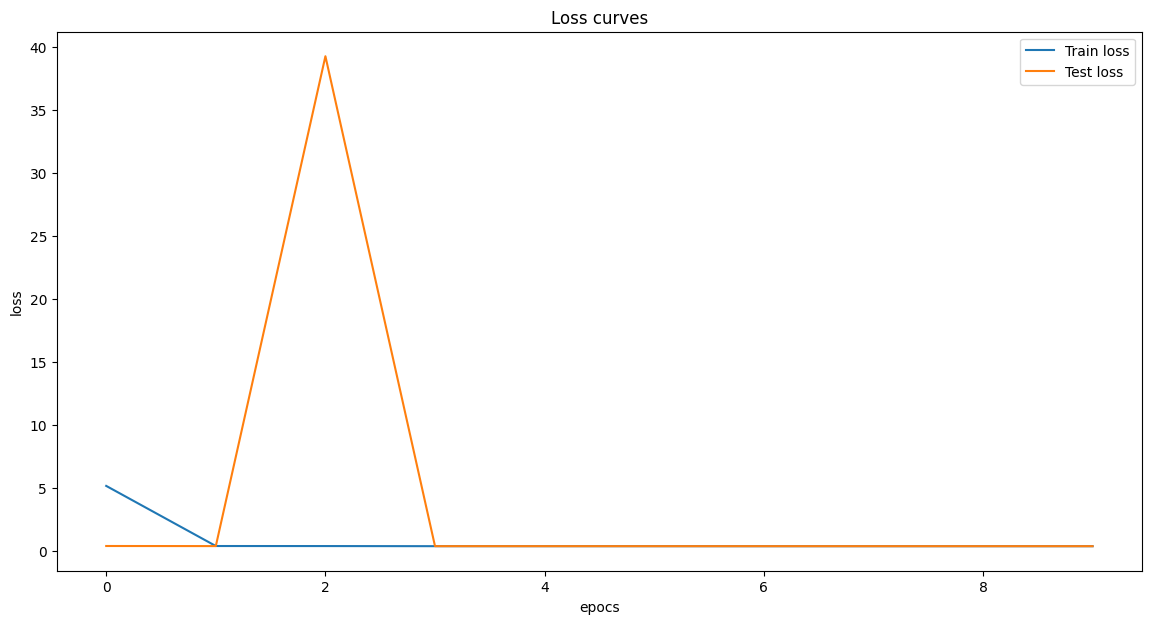

In [147]:
epoch_values = [i for i in range(n_epochs)]
plt.figure(figsize=(14, 7));
plt.plot(epoch_values, train_loss_values, label='Train loss')
plt.plot(epoch_values, test_loss_values, label='Test loss')
plt.title('Loss curves')
plt.xlabel('epocs')
plt.ylabel('loss')
plt.legend();

## <font color='red'> Todo </font>
1. Include learning rate scheudler  <font color='green'> **Done** </font>
2. Write prediction code, generate submission file, and submit  <font color='green'> **Done** </font>
3. Train RF model and see the performance on raw-data
4. Train RF model on the generated embeddings from NN model and see the performance
5. Keep pushing code to github

## Prediction

In [202]:
def predict_with_model(model, device, test_dataset, batch_size):
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

    # model to evaluation mode
    model = model.to(device)
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X = torch.tensor(X, dtype=torch.long).to(device)
            logits = model(X).squeeze()
            pred_labels = torch.sigmoid(logits)
            # print(f"pred_labels.shape: {pred_labels.shape}")
            # pred_labels.item()
            pred_labels_list = [elem for elem in pred_labels.detach().cpu().numpy()]  # convert from tensor in gpu to numpy in cpu
            predictions.append(pred_labels_list)
            
    predictions = [elem for batch_preds in predictions for elem in batch_preds]
    return predictions

## Convert test data to Dataset

In [203]:
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,600000,1,1,1,1,2,1,2,1,4,...,2197,3,5,1,6,21,147,3,12,-1
1,600001,1,1,1,1,2,3,1,5,6,...,1108,1,5,2,14,14,0,2,11,-1
2,600002,1,1,1,1,2,1,1,1,6,...,813,1,2,6,9,14,13,2,9,-1
3,600003,2,1,1,1,1,3,2,1,3,...,997,1,2,4,13,2,1,1,9,-1
4,600004,1,1,2,1,2,3,1,0,4,...,372,1,1,5,15,10,15,3,6,-1


In [204]:
test_ds = DFToDataset(df=test, features=features, target_column='target')

In [208]:
predictions = predict_with_model(model=model_v1, device=device, test_dataset=test_ds, batch_size=1024)  # batch_size can be different from the one used while training

In [210]:
len(predictions)
predictions[:5]

400000

[0.17791753, 0.29174346, 0.13055322, 0.0627737, 0.12879151]

### Generate submission file 

In [197]:
submission_df = pd.DataFrame(columns=['id', 'target'])
submission_df
submission_df['id'] = test.id
submission_df['target'] = predictions

submission_df.shape
submission_df.head()

,id,target


(400000, 2)

,id,target
0,600000,0.177918
1,600001,0.291743
2,600002,0.130553
3,600003,0.062774
4,600004,0.128792


In [198]:
submission_df.to_csv('../data/output/catg_enc_submission.csv', index=False)

## Upload submission file to Kaggle